# Read & Explore the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
ratings = pd.read_csv('ratings_Electronics.csv')

In [3]:
ratings.head()
# No Column Name in the dataset

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
# Add column names first
colnames = ['userId', 'productId', 'Rating', 'timestamp']
ratings = pd.read_csv('ratings_Electronics.csv', names = colnames)
ratings.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
# As timestamp will not be used for model building, let's drop the column
ratings = ratings.drop('timestamp', axis = 1)

In [6]:
# Summary Statistics of 'rating' variable
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


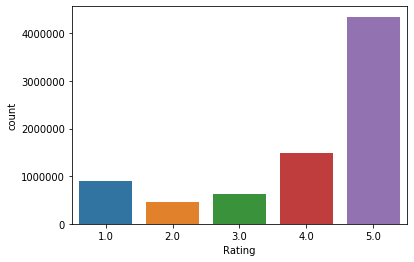

In [7]:
# Check the distribution of ratings
sns.countplot(ratings['Rating'], linewidth = 10)

In [8]:
# Checking number of missing values
ratings.isna().sum()
# No missing values

userId       0
productId    0
Rating       0
dtype: int64

# Keep Users who have 50 or more ratings

In [9]:
counts = ratings['userId'].value_counts()

In [10]:
ratings_new = ratings[ratings['userId'].isin(counts[counts >= 50 ].index)]

In [11]:
ratings_new.head()

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


# Split the data into training & test set

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
trainset, testset = train_test_split(ratings_new, test_size = 0.3, random_state = 0)

# Popularity Based Recommendation System

In [14]:
trainset.groupby('productId')['Rating'].mean().sort_values(ascending = False).head()
# However, we don't know the number of users for the products

productId
0594451647    5.0
B004SBCF4Q    5.0
B000TUGSC0    5.0
B000TTMJ2E    5.0
B000TSZ51W    5.0
Name: Rating, dtype: float64

In [15]:
trainset.groupby('productId')['Rating'].count().sort_values(ascending = False).head()

productId
B0088CJT4U    133
B007WTAJTO    124
B003ES5ZUU    122
B000N99BBC    114
B00829TIEK     97
Name: Rating, dtype: int64

In [16]:
trainset_mean_count = pd.DataFrame(trainset.groupby('productId')['Rating'].mean())

In [17]:
trainset_mean_count['ratings_count'] = pd.DataFrame(trainset.groupby('productId')['Rating'].count())

In [18]:
# Sort the products on recommendation score
trainset_sort = trainset_mean_count.sort_values(['Rating','productId'], ascending = [0,1])
# Generate a recommendation rank based upon Rating
trainset_sort['Rank'] = trainset_mean_count['Rating'].rank(ascending = 0, method = 'first')
# Get top 5 recommendations
trainset_recommendations = trainset_sort.head()
trainset_sort.head()

,Rating,ratings_count,Rank
productId,,,
0594451647,5.0,1,1.0
0972683275,5.0,3,2.0
1400532620,5.0,1,3.0
1400698987,5.0,1,4.0
1685560148,5.0,1,5.0


In [19]:
# Use popularity based recommender model to make predictions
def recommend(user_id):
    user_recommendations = trainset_recommendations
    
    # Add user_id column for which the recommendations are being generated
    user_recommendations['user_id'] = user_id
    
    # Bring user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]
    
    return user_recommendations

In [20]:
find_recom = [15,121]
for i in find_recom:
    print("Here is the recommendation for user id: %d\n" %(i))
    print(recommend(i))
    print("\n") 

Here is the recommendation for user id: 15

            user_id  Rating  ratings_count  Rank
productId                                       
0594451647       15     5.0              1   1.0
0972683275       15     5.0              3   2.0
1400532620       15     5.0              1   3.0
1400698987       15     5.0              1   4.0
1685560148       15     5.0              1   5.0


Here is the recommendation for user id: 121

            user_id  Rating  ratings_count  Rank
productId                                       
0594451647      121     5.0              1   1.0
0972683275      121     5.0              3   2.0
1400532620      121     5.0              1   3.0
1400698987      121     5.0              1   4.0
1685560148      121     5.0              1   5.0




# Evaluate Popularity Based Model

In [21]:
testset_grouped = pd.DataFrame(testset.groupby('productId')['Rating'].mean())
testset_grouped.head()

,Rating
productId,
0970407998,4.0
0972683275,4.0
1400501466,1.0
1400501520,5.0
1400532620,1.0


In [22]:
testset_grouped.shape

(21292, 1)

In [24]:
# We need to compare average rating of products in test with that in train
ts = trainset_mean_count.drop('ratings_count', axis = 1)
print(ts.shape)

(38226, 1)


In [25]:
df = pd.merge(testset_grouped, ts, on = 'productId')
df.head()

,Rating_x,Rating_y
productId,,
0970407998,4.0,1.0
0972683275,4.0,5.0
1400501466,1.0,4.5
1400532620,1.0,5.0
1400532655,5.0,3.6


In [26]:
RMSE = round((((df.Rating_x - df.Rating_y) ** 2).mean() ** 0.5), 5)
print('\nRMSE Popularity Model = {} \n'.format(RMSE))


RMSE Popularity Model = 1.09722 



# Collaborative Filtering Model

In [27]:
# We need to regenerate test & train set due to surprise library; Although we keep the random state same as previously
# We merge the train & test set first
df_CF = pd.concat([trainset, testset]).reset_index()
df_CF.head()

,index,userId,productId,Rating
0,6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
1,4738241,AB094YABX21WQ,B0056XCEAA,1.0
2,4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3,3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
4,1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [28]:
from surprise import Dataset, Reader
from surprise import accuracy
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split

In [29]:
reader = Reader(rating_scale = (1,5))

In [30]:
data = Dataset.load_from_df(df_CF[['userId', 'productId', 'Rating']], reader = reader)

In [31]:
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 0)

In [32]:
algo = KNNWithMeans(k = 10, sim_options = {'name': 'pearson_baseline', 'user_based': True})

In [33]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [34]:
# We can now query for specific predictions
uid = str(196)
iid = str(302)

In [35]:
# Get a prediction for specific users & items
pred = algo.predict(uid, iid, verbose = True)

user: 196        item: 302        r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


In [36]:
# run the trained model on test set
test_pred = algo.test(testset)

In [37]:
test_pred

[Prediction(uid='A2KHG3JOFXQ4CE', iid='B000RZQZM0', r_ui=3.0, est=4.148017062048868, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A3H4S6YO9VNGDZ', iid='B009NB8WR0', r_ui=5.0, est=4.9985224356481845, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A357B3PUHSVQA', iid='B0086KP1I2', r_ui=3.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2NOIWPJDD7WIQ', iid='B008QJXPGS', r_ui=2.0, est=4.261573732535837, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3GX0FAMEXV6FB', iid='B0079R2MH6', r_ui=5.0, est=4.261573732535837, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A20DZX38KRBIT8', iid='B000HZ48OM', r_ui=2.0, est=4.261573732535837, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3PD8JD9L4WEII', iid='B0055OPXZ8', r_ui=5.0, est=4.338383838383838, details={'actual_k': 0, 'was_impossibl

In [38]:
# Get RMSE
accuracy.rmse(test_pred, verbose = True)

RMSE: 1.0623


1.0622840583836601

# Top 5 recommendations for the user

In [39]:
from collections import defaultdict
def get_top_n(test_pred, n = 5):
    # First map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in test_pred:
        top_n[uid].append((iid, est))
    
    # Then retrieve the predictions of each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x:x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [40]:
top_n = get_top_n(test_pred, n = 5)

In [41]:
top_n

defaultdict(list,
            {'A2KHG3JOFXQ4CE': [('B00BOHNYTW', 4.576811699929177),
              ('B0031RG29M', 4.567765567765568),
              ('B002FYL7PG', 4.456345931429704),
              ('B001VEI290', 4.261573732535837),
              ('B000RZQZM0', 4.148017062048868)],
             'A3H4S6YO9VNGDZ': [('B0012MMW7E', 5),
              ('B0011YZJPA', 5),
              ('B009NB8WR0', 4.9985224356481845),
              ('B002BH3Z8E', 4.815624649984447),
              ('B008OZF9SQ', 4.7170113836780505)],
             'A357B3PUHSVQA': [('B00IVPU786', 4.95945945945946),
              ('B00CRY250U', 4.933333333333334),
              ('B004CLYEAK', 4.76347322438747),
              ('B000N99BBC', 4.724921839868227),
              ('B008X1BV2Y', 4.553957098239458)],
             'A2NOIWPJDD7WIQ': [('B000KKPN5C', 4.509722222222222),
              ('B00DB3SH2G', 4.470742932281394),
              ('B00DVFLJDS', 4.470742932281394),
              ('B00005LEN4', 4.4135457264538696),
        

# Inferences

1. Popularity Based model recommend the same sets of products for every user.
2. Collaborative filtering recommends products after taking due consideration of preferences of the user and varies from one to another.
3. When we observe the prediction of test set of collaborative filtering, we find that was_impossible is True for some of the users. This means that those users have no neighbors i.e. they suffer from either cold start or grey ship problems.
4. We have chosen no of neighbors as 10 for user based collaborative filtering. But, in many cases, we can see actuals no of neighbors is lower than 10 in the prediction of test set.